# An Introduction to Information Theory

* Basics
    * Entropy
    * Joint Entropy
    * Conditional Entropy
    * Mutual Information
    * KL Divergence
    * Conditional Mutual Information
* Trees
    * Decision Tree (C4.5)
        * Universal Approximators
        * Example
        * Psuedo Code
        * Algorithm Implementation
        * feature importances
        * tree interpreter
        * lime
        * SHAP
    * Random Forests
        * High Level Psuedo Code
        * Example
        * tree interpreter
        * lime
        * SHAP
    * Gradient Boosted Trees
        * High Level Psuedo Code
        * Example
        * tree interpreter
        * lime
        * SHAP
    * XG-Boosted Trees
        * Differences from Gradient Boosted Trees
        * Example
        * tree interpreter
        * lime
        * SHAP
    * Cat Boost
        * Use-Case
        * Example
        * SHAP

## Information Theory Basics

### A quick review of the probability:

The _probability_ of an event X is how likely it is to occur over the long term.

Example:

What is the probability that if you flip a coin it comes up heads?

Given two cases:

* Heads
* Tails

The result should be:

$$ \frac{\textrm{Desired Case}}{\textrm{Total Cases}} $$

Therefore:

$$ \frac{\textrm{Head Case}}{\textrm{Total Cases}} = \frac{1}{2} $$

In [35]:
import random

def generate_coin_flips(n):
    cases = ["H", "T"]
    probabilities = {
        'H': 0,
        'T': 0
    }
    for _ in range(n):
        probabilities[random.choice(cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

generate_coin_flips(10)

{'H': 0.3, 'T': 0.7}

In this case we got tails more frequently than heads!  Does that mean we got it wrong?! No!

That's because we end up with 50% probability over the long run.  Let's see how many times we need to flip a coin for the number of times to get 50% probability!

In [8]:
generate_coin_flips(999999)

{'H': 50049.3, 'T': 49950.6}

As you can see we get closer.  Let's see the path to 50% heads:

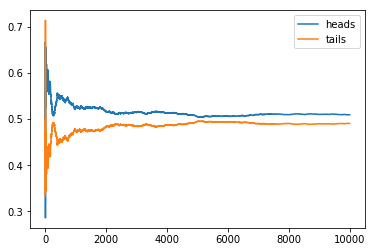

In [22]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

def generate_coin_flips(n):
    cases = ["H", "T"]
    occurrences = [random.choice(cases) for _ in range(n)]
    probabilities = []
    for index in range(len(occurrences)):
        if occurrences[:index].count("H") == 0 or occurrences[:index].count("T") == 0:
            continue
        probabilities.append({
            "H": occurrences[:index].count("H")/index,
            "T": occurrences[:index].count("T")/index
        })
    return probabilities

probabilities = generate_coin_flips(10000)

x = list(range(len(probabilities)))
heads = [probabilities[index]["H"] for index in range(len(probabilities))]
tails = [probabilities[index]["T"] for index in range(len(probabilities))]
plt.plot(x, heads, label="heads")
plt.plot(x, tails, label="tails")
plt.legend()

As we can see, the probabilities diverge wildly for the first few flips and then eventually they normalize to close to 50% each.  This is what the probability really is saying, it's the likelihood of the event eventually, over many trials.

This is known as the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) and is possibly the most important theorem in probability and statistics for non-time series data.

## Entropy

Now that we've looked at the basics of probability, let's look at our first information theoretic notion - Entropy.   Generally, information entropy is the average amount of information conveyed by an event, when considering all possible outcomes.

The formula for Entropy is:

$$ H = - \sum_{i} p_{i} log_{2}p_{i}  $$

Entropy comes to us from information theory, primarily used for encoding symbols on a wire.  To understand this, consider wanting to create a binary encoding of the alphabet to pass along a wire.  Would you use the same number of symbols for each letter?  Or would some symbols use shorter encodings so they can be passed along the wire more easily?  It turns out we can decide how to encode each letter of the alphabet in this scenario using a probabilistic approach.  That is, we can start with a uniform encoding scheme and then observe the probability of each symbol across the wire.  We can then observe the probabilities of each symbol and adjust our encoding to minimize entropy.  This represents the numbering system in the encoding via the subscript of the log - so a log base 2 assumes a binary encoding scheme.  log base 3 assumes a trianary encoding scheme and so on.


Interestingly, entropy's uses extend well beyond it's initial use case.  As you can see the Entropy makes use of the probability.  As the equation shows us, Entropy is a scaled negative of the probability mass function.  So we can see entropy as sort of like the inverse of a probability.  Two common descriptions of Entropy beyond it's initial use case:

* The 'surprise' of an event - IE low probability events carry more information than more common events.  That's because if a more common event occurs, we get the predictable outcome.  But if a very unlikely event occurs, we learn a lot from that trial, even more so, we learn a lot about that system.
* The disorder within a system 

Interestingly, when all events are equally likely the entropy is maximized.

So for example:

Say we wanted to figure out if a dice was fair, we could use entropy to measure if it is indeed fair:

In [39]:
import random
import math

def generate_dice_rolls(cases, n):
    probabilities = {
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0, 
        6: 0
    }
    for _ in range(n):
        probabilities[random.choice(cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

def entropy(probabilities):
    return -1 * sum([probabilities[case]*math.log(probabilities[case]) 
                     for case in probabilities])

cases = [1, 2, 3, 4, 4, 4, 5, 5, 6]
probabilities = generate_dice_rolls(cases, 1000)
print("Weighted Dice", entropy(probabilities))
cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls(cases, 1000)
print("Fair Dice", entropy(probabilities))

Weighted Dice 1.6598301582773598
Fair Dice 1.7903953067307885


Notice, we are able easily discern that the entropy is smaller for the weighted or "biased" dice compared to the fair dice.  This notion will be important when we go over trees.

## Joint Probability

The joint probability is the probability of two events occurring at the same time.  Assuming the events are mutually exclusive, meaning they don't depend on each other, then the formula is:

$$ p(x, y) = p(x) * p(y) $$

Assuming the events depend on each other we then have a dependency structure to our joint probability:

$$ p(x, y) = p(x | y) * p(y) $$

-OR-

$$ p(x, y) = p(y | x) * p(x) $$

Let's see how the first case looks:

Assume you have two fair dice, what's the probability of getting two 1's, aka snake eyes?

Formmally that is:

$$ Pr(X=1 | Y=1) = \frac{1}{6} * \frac{1}{6} = \frac{1}{36}$$

Now let's see how to calculate this programmatically:

In [11]:
import random
import math
import itertools

def generate_dice_rolls_joint(cases, n):
    total_cases = [elem for elem in itertools.permutations(cases, 2)] + [(elem, elem) for elem in cases]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls_joint(cases, 999999)
probabilities

{(1, 2): 0.02767902767902768,
 (1, 3): 0.027735027735027735,
 (1, 4): 0.027605027605027605,
 (1, 5): 0.027613027613027613,
 (1, 6): 0.027728027728027727,
 (2, 1): 0.027853027853027852,
 (2, 3): 0.02794702794702795,
 (2, 4): 0.02783802783802784,
 (2, 5): 0.027456027456027456,
 (2, 6): 0.028107028107028108,
 (3, 1): 0.02796802796802797,
 (3, 2): 0.02774202774202774,
 (3, 4): 0.0278990278990279,
 (3, 5): 0.027945027945027946,
 (3, 6): 0.02791002791002791,
 (4, 1): 0.027703027703027704,
 (4, 2): 0.027587027587027586,
 (4, 3): 0.027682027682027682,
 (4, 5): 0.02783202783202783,
 (4, 6): 0.02762102762102762,
 (5, 1): 0.027755027755027754,
 (5, 2): 0.0279000279000279,
 (5, 3): 0.02767902767902768,
 (5, 4): 0.027773027773027772,
 (5, 6): 0.0277990277990278,
 (6, 1): 0.02775102775102775,
 (6, 2): 0.02804102804102804,
 (6, 3): 0.02791902791902792,
 (6, 4): 0.027619027619027618,
 (6, 5): 0.027886027886027887,
 (1, 1): 0.02755002755002755,
 (2, 2): 0.027816027816027815,
 (3, 3): 0.0277070277070277

Here most of the probabilities are around 0.027 which is approximately $ \frac{1}{36} $.  So we were able to recover a calculation which matches approximately with our theoretical guess!

Now let's look at a case where the probability of a given random variable is dependent on another random variable:

For this let's assume we are playing a simple card game:  

What's the probability of drawing the 3 of diamonds and drawing a heart?

$$ Pr(\textrm{3 of diamonds}|heart) * Pr(heart) * 2= \frac{1}{51} * \frac{13}{52} * 2= \frac{26}{2652} $$

In [16]:
import random
import math
import itertools
import collections

# Stolen from here: https://github.com/fluentpython/example-code/blob/master/01-data-model/frenchdeck.py
Card = collections.namedtuple('Card', ['rank', 'suit'])

class FrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]
    
def generate_conditional_deck_joint_probability(deck, n):
    total_cases = [elem for elem in itertools.combinations(deck, 2)] 
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    probabilities = {case:probabilities[case]/n for case in probabilities}
    cases_of_interest = {}
    for case in probabilities:
        first_condition = case[0].suit == "diamonds"
        second_condition = case[0].rank == '3'
        third_condition = case[1].suit == "hearts"
        if first_condition and second_condition and third_condition:
            cases_of_interest.update({case: probabilities[case]})
    return sum(list(cases_of_interest.values()))

   
deck = FrenchDeck()
probabilities = generate_conditional_deck_joint_probability(deck, 999999)
probabilities

0.00984300984300984

Just to verify: 

$$ \frac{26}{2652} \approx 0.0098 $$

Which is pretty close to what we got!

## Joint Entropy

Now that we have the notion of joint probability we can analyze the joint entropy of two random variables.  The notions here are more or less the same - assuming the random variables are independent, the joint entropy is the joint 'surprise' of two events.  If the joint probability of all events in the space are equally likely, then the event space is said to be maximized.

Let's look at the formula for joint entropy:

$$ H(X, Y) = - \sum_{x,y} \textrm{p(x, y) log p(x,y)} $$

Returning to our dice example, let's consider two cases now:

1. When the dice are fair
2. When the dice are weighted

Weighted dice are employed by charlatans to deceive gamblers out of money.  So, we can test empirically whether or not a pair of dice are weighted, if we wish to inspect whether or not a casino uses fair dice, as follows:

In [17]:
import random
import math
import itertools

def generate_dice_rolls_joint(cases, n):
    total_cases = [elem for elem in itertools.permutations(cases, 2)] + [(elem, elem) for elem in cases]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n for case in probabilities}

def entropy(probabilities):
    return -1 * sum([probabilities[case]*math.log(probabilities[case]) 
                     for case in probabilities])

cases = [1, 2, 3, 4, 4, 4, 5, 5, 6]
probabilities = generate_dice_rolls_joint(cases, 1000)
print("Weighted Dice", entropy(probabilities))
cases = [1,2,3,4,5,6]
probabilities = generate_dice_rolls_joint(cases, 1000)
print("Fair Dice", entropy(probabilities))

Weighted Dice 3.3438375882883706
Fair Dice 3.5679159556113405


Notice that in this case the code for calculating entropy doesn't change, this is because we implicitly have a joint probability from the calculation above.

Also, notice that the weighted dice has a lower entropy than the fair dice showing, in fact, we can discern entropy in a multivariate state reliably.

## Conditional Joint Entropy

Now that we now how to handle the case when there is some dependency between the two random variables.  First let's right down the formula:

$$ H(X|Y) = - \sum_{y \in Y} p(y) \sum_{x \in X} \textrm{p(x|y) log p(x|y)} = - \sum_{x,y} \textrm{p(x,y) log p(x|y)} $$

As you can see from the above definition we consider the the total probability of y and the probability of X conditioned on Y.  So we can treat the conditional joint entropy of X given Y as the average conditional entropy over Y.

More generally, we can think of the conditional joint entropy as the surprise of X given Y.

Returning to our example from choosing cards, we can use the conditional joint entropy to tell if two decks (or possibly two dealers) are fair.  If they are, the conditional joint entropy should be maximized:


In [19]:
import random
import math
import itertools
import collections

# Stolen from here: https://github.com/fluentpython/example-code/blob/master/01-data-model/frenchdeck.py
Card = collections.namedtuple('Card', ['rank', 'suit'])

class FairFrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]

class UnfairFrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()

    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits
                                        for rank in self.ranks]
        # making hearts and diamonds more likely than spades or clubs
        self._cards += [Card(rank, suit) for suit in ["hearts", "diamonds"]
                                         for rank in self.ranks]

    def __len__(self):
        return len(self._cards)

    def __getitem__(self, position):
        return self._cards[position]

def generate_conditional_deck_joint_probabilities(deck, n):
    total_cases = [elem for elem in itertools.combinations(deck, 2)] 
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    probabilities = {case:probabilities[case]/n 
                     for case in probabilities}
    cases_of_interest = {}
    for case in probabilities:
        first_condition = case[0].suit == "diamonds"
        second_condition = case[0].rank == '3'
        third_condition = case[1].suit == "hearts"
        if first_condition and second_condition and third_condition:
            cases_of_interest.update({case: probabilities[case]})
    return cases_of_interest

def generate_deck_probabilities(deck, n):
    total_cases = [card for card in deck if card.suit == "hearts"]
    probabilities = {}.fromkeys(total_cases, 0)
    for _ in range(n):
        probabilities[random.choice(total_cases)] += 1
    return {case:probabilities[case]/n 
           for case in probabilities}
    
def conditional_entropy(probabilities, joint_probabilities):
    p_y = sum(list(probabilities.values()))
    p_x_given_y = sum([joint_probabilities[case]*math.log(joint_probabilities[case]) 
                     for case in joint_probabilities])
    return -1 * p_y * p_x_given_y 

fair_deck = FairFrenchDeck()
n = 999999
joint_probabilities = generate_conditional_deck_joint_probabilities(fair_deck, n)
probabilities = generate_deck_probabilities(fair_deck, n)
print("Fair deck, Conditional Joint Entropy", conditional_entropy(probabilities, joint_probabilities))
unfair_deck = UnfairFrenchDeck()
joint_probabilities = generate_conditional_deck_joint_probabilities(unfair_deck, n)
probabilities = generate_deck_probabilities(unfair_deck, n)
print("Unfair deck, Conditional Joint Entropy", conditional_entropy(probabilities, joint_probabilities))

Fair deck, Conditional Joint Entropy 0.07114769929362579
Unfair deck, Conditional Joint Entropy 0.06308279612598472


As we can see, the entropy is maximized when the deck is fair!  So, we could watch the hands that are dealt at a given casino and if the entropy of all observed hands doesn't meet the conditional joint entropy, then it's likely there is some foul play at foot!

## Cross Entropy 

Cross Entropy is best described initially with a return to it's first use case - encoding information on a wire.  Suppose you have two communication channels - both channels are in english and use the same alphabet.  What if you want to how different the optimal encoding scheme is for one channel versus another.  This is a perfect use case for cross entropy!

$$ H(p, q) = - \sum_{x \in X} p(x) log q(x) $$

As you can see from the equation, we look at the same space of symbols needed to be encoded, IE, the same space of data to be measured and to _distinct_ probability distributions for the data.  

The Cross Entropy can tell us how similar the two probability distributions are, in terms of information gain.  When they are the same the cross entropy is as small as possible, that is when `p = q`.  

Cross Entropy is also a great measure for comparing observed data versus that for a model in binary or multi class classification.  Recall that a model is merely an application maximum likelihood estimation (MLE), IE recovering the most likely fit parameters for a multi-variate distribution.  Therefore, when we make use of cross entropy we are assessing our the quality of our data generated by first applying MLE and comparing it to the "natural generation process" that supplied us with our ground truth data.

The lower the cross entropy, the closer the model is to the observed dataset.  And therefore, we can expect our model or synthetic data generation process, to be closer the process that generated our data.

Let's look at our first real world example of entropy, for this we'll make use of some sklearn magic!

In [44]:
from sklearn.datasets import load_iris
from sklearn import ensemble
from sklearn import metrics

data = load_iris()
rf = ensemble.RandomForestClassifier()
rf.fit(data.data, data.target)
y_pred = rf.predict_proba(data.data)
metrics.log_loss(data.target, y_pred)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.03067323365612531

As you can see, the cross entropy is quiet small, so we can likely trust the model does a very good job.  Notice that the cross entropy assumes your model predictions are in terms of probabilities for the predicted results.  In case you are wondering of how well this model does in terms of precision and recall:

In [46]:
y_pred = rf.predict(data.data)
print(metrics.classification_report(data.target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      1.00      0.98        50
           2       1.00      0.96      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



As you can see, this model essentially gets everything right in terms of precision _and_ recall!  In fact it correctly classifies all of the examples from 2 out of the three classes!!!

## Mutual Information


Mutual information is a measure of how much information is shared between two variables.  To understand the motivation behind this measure let's return again to our original context of encoding information on a wire.  Mutual information in specific measures the distribution of data before it is sent across a wire and after.  It's formula is expressed as:

$$ I(X;Y) = \sum_{x,y} p(x,y) log \frac{p(x,y)}{p(x)p(y)} $$

This formula more or less compares the ratio in information between the joint probability of the variables taken together against the marginal probabilities being composed.  Notice that if the variables are independent than this ratio is 1 and if the variables are the same, this ratio is 0.  Since `log 1 = 0`, when the variables are independent the mutual information is zero and when the two variables are the same the mutual information is maximized.

Using the above analysis, we can see that mutual information can be used to measure independence between two variables.  In general, the mutual information is a measure on the information gained between two variables.  Returning to our example of information passing over a wire, we can see mutual information as how much information gain we observe from the received messages as compared with the sent.  So we can assess whether or not the wire has manipulated the distribution across an action.

One of the nice properties of mutual information as a measure is, it does not assume an underlying distribution about it's two random variables.  Thus we have a general purpose measure of independence.

Let's look at a few worked examples:

In [47]:
from sklearn import feature_selection
import seaborn as sns
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY


In [56]:
features = ["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium"]
X = crashes[features]
y = crashes["total"]
ranks = feature_selection.mutual_info_regression(X, y)
rankings = []
for index, feature in enumerate(features):
    rankings.append((feature, ranks[index]))
sorted(rankings, key=lambda t: t[1], reverse=True)

[('not_distracted', 1.1122296149948283),
 ('no_previous', 1.0650950506291723),
 ('alcohol', 0.6553972972460005),
 ('speeding', 0.3147170761329834),
 ('ins_premium', 0.0988608669016986)]

Here we see the `not_distracted` has the highest mutual information, so we should expect it to be a good predictor for total car crashes per 50,000 miles.  Interestingly, we can also make use of mutual information as a measure of the fit of for a given model:

In [60]:
from sklearn import ensemble
from sklearn import metrics

features = ["alcohol", "not_distracted", "no_previous"]
X = crashes[features]
y = crashes["total"]
gbt = ensemble.GradientBoostingRegressor()
gbt.fit(X, y)
y_pred = gbt.predict(X)
metrics.mutual_info_score(y, y_pred)

3.768732178474927

So we can say there is likely some mutual information between the predicted and seen target column!  This means this model is probably at least an okay fit.

## KL - Divergence

KL-Divergence is a way of comparing a true distribution against some arbitrary probability distribution.  We can think of it as the "unnecessary surprise" from a model to some true model.  

$$ D_{KL}(p(X)||q(X)) = \sum_{x \in X} p(x) log \frac{p(x)}{q(x)} $$

As you can see, the KL-Divergence is the ratio of the correct distribution to the arbitrary distribution.  KL-Divergence is a natural fit for assessing the divergence in a supervised learning problem.  Let's look at an example:

In [66]:
from sklearn import ensemble
from sklearn import metrics
from scipy import stats

features = ["alcohol", "not_distracted", "no_previous"]
X = crashes[features]
y = crashes["total"]
gbt = ensemble.GradientBoostingRegressor()
gbt.fit(X, y)
y_pred = gbt.predict(X)
stats.entropy(y, qk=y_pred)

1.5176955469736423e-05

As you can see the divergence is quite small.  So we can say this model is probably a good fit!  Note - KL divergence is not a true metric because it does not satisfy the triangle inequality and is therefore not well ordered.  Therefore you cannot use it as a comparison between two models.  However, it is still used often across many algorithms and can be used in many contexts, because of it's flexability.  

# Trees

Now that we under how Entropy works, we can look at a class of models that make use of it to model data - Tree based models!  At a very high level, Tree based models are universal approximators, in that they don't require _any_ distribution information to fit data.  In fact, the only cases they tend to do really poorly on are those where the data is very clearly linearly seperated.  This is because of how tree based models fit the data.  But rather than tell you about it - let's look at a very simple worked example:

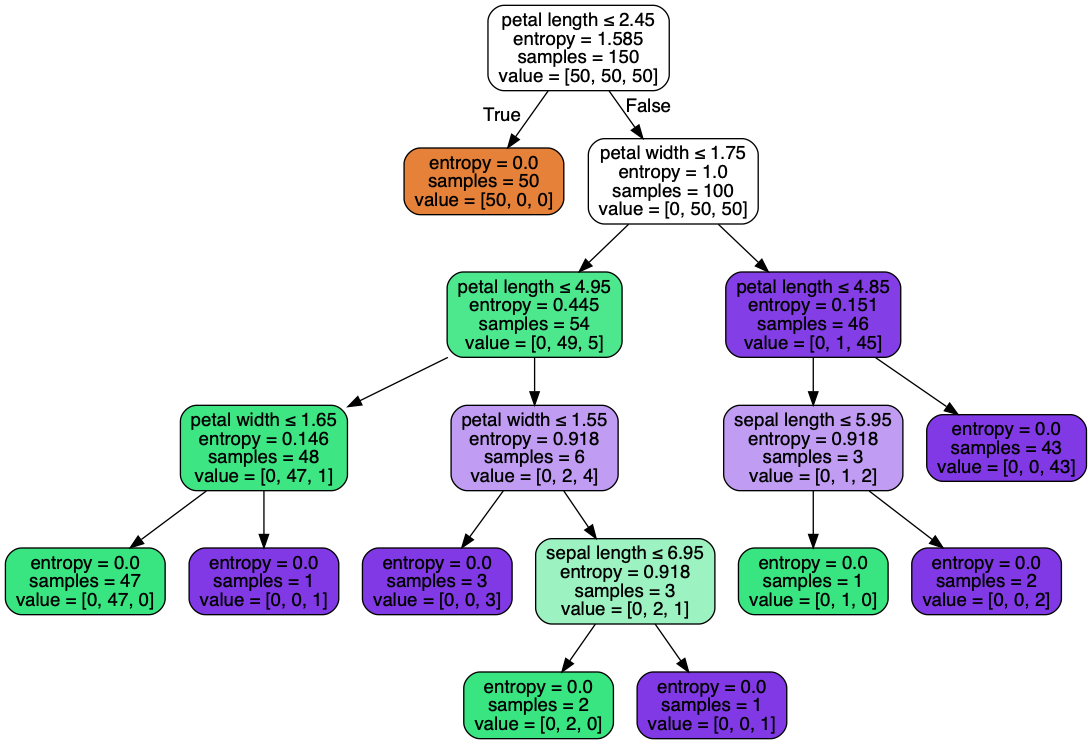

In [79]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data = load_iris()
c45 = tree.DecisionTreeClassifier(criterion="entropy")
c45.fit(data.data, data.target)
y_pred = c45.predict(data.data)

dot_data = StringIO()
export_graphviz(c45, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=["sepal length","sepal width","petal length", "petal width"],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As you can see, the decision tree breaks the data into buckets of data.  Essentially segmenting the dataset such that the entropy is minimized.  The notion here is that data with low entropy is highly ordered.  In doing this ordering, the final nodes are all of one class.  So tracing from the top of the tree to the bottom, we can sort every single row based on the rules that decide how the information flows from root to leaf.

**Note**: that Entropy includes a logarithm in it's computation, so trees are well suited for big datasets.  Typically they aren't useful for less than 100 data points.

## Psuedo Code

Now that we understand approximately how Decision Trees work, let's look at the psuedo code so we can see how Entropy is used:

1. Start at the root node.
2. For each X: 

    find $\{S\}$ s.t. $\sum_{ni \in CN} $

    choose split st. split $\{X \in S\}$ 

    gives minimum overall $\{X \in S\}$
    

3. If a stopping criterion is reached, exit. Otherwise, apply step 2 to each child node in turn.


where ni is node impurity
where CN is child Nodes

As you can see the basic notion is to find the split that minimizes the sum of the impurity for the resultant child nodes.  Trees can basically be seen as a recursive algorithm, where we keep going until we reach some stopping criteria.

Reference:

* [gini implementation](https://medium.com/machine-learning-101/chapter-3-decision-trees-theory-e7398adac567)
* [entropy implementation](https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928)

## Implementation

Now that we've look at the psuedo code, let's look at a naive implementation of the decision tree classification algorithm:

In [84]:
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log

def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
def find_entropy_attribute(df,attribute):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]
  
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)

def buildTree(df,tree=None): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    
    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Eat'],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

def predict(inst,tree):
    #This function is used to predict for any input variable 
    
    #Recursively we go through the tree that we built earlier

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

dataset = {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
       'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
       'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
       'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}

df = pd.DataFrame(dataset,columns=['Taste','Temperature','Texture','Eat'])
tree = buildTree(df,tree=None)
data = {"Taste": "Salty", "Temperature": "Cold", "Texture": "Hard"}
example = pd.Series(data)
prediction = predict(example, tree)
prediction

'Yes'

TODO: Explain implementation

## Interpretting Decision Tree Results

Now that we have a universal approximator, we don't need to care about distributions anymore!  No more thinking about GLMs or any of that costly distribution fitting stuff we did before!  But is there a cost to not knowing how your data is distributed?  It turns out the answer is yes.  Without knowing the distributions, you can't interpret your results the same way.

Without the assumptions of a distribution, we can't even say how confident we are about the importance of _any_ of the features of our model, in absolute terms.  However, we can saw how relatively important each feature is _with respect to_ the model.  That said, we won't know if any of our features are statistically significant, generally speaking.  This means our entire model could be spurious and we wouldn't necessarily know it.

That isn't to say that decision trees or any of the other universal approximators we'll look at are useful, it just means that we'll need to be sure our features have some sense of semantic relation, otherwise our model may have no semantic value.

### Feature Importance

Let's assume that our features are important and our model isn't spurious, just for a moment.  How might we tell which features are important?  Well, it turns out that decision trees come with a nice method for doing this called feature importance.

Let's see how it works with an example:

In [9]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data = load_iris()
feature_names=["sepal length","sepal width","petal length", "petal width"]
c45 = tree.DecisionTreeClassifier(criterion="entropy")
c45.fit(data.data, data.target)
y_pred = c45.predict(data.data)

feature_importances = []
for index, feature_name in enumerate(feature_names):
    feature_importances.append((feature_name, c45.feature_importances_[index]))
sorted(feature_importances, key=lambda t:t[1], reverse=True)

[('petal width', 0.9107589762872454),
 ('petal length', 0.0776534204270406),
 ('sepal length', 0.011587603285713902),
 ('sepal width', 0.0)]

As you can see, we can tell how relatively important each feature is for the model.  Let's see if this matches up with our mutual information method from before:

In [6]:
from sklearn import feature_selection
features=["sepal length","sepal width","petal length", "petal width"]
X = data.data
y = y_pred
ranks = feature_selection.mutual_info_regression(X, y)
rankings = []
for index, feature in enumerate(features):
    rankings.append((feature, ranks[index]))
sorted(rankings, key=lambda t: t[1], reverse=True)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


[('petal width', 1.014421443570952),
 ('petal length', 0.9803069290280182),
 ('sepal length', 0.47331977136827286),
 ('sepal width', 0.20392354392560108)]

As you can see, the feature importance within the tree and the mutual information rankers both give the features the same amount of importance.  

Because these measures don't have any strong semantic meaning in general, we can't really interpret the actual numbers found along side any of these features but only the relative ranking of each of the features.

Let's see if we can draw any connections between the feature importances and the tree we end up drawing.  Just to remind you, it looks like this:

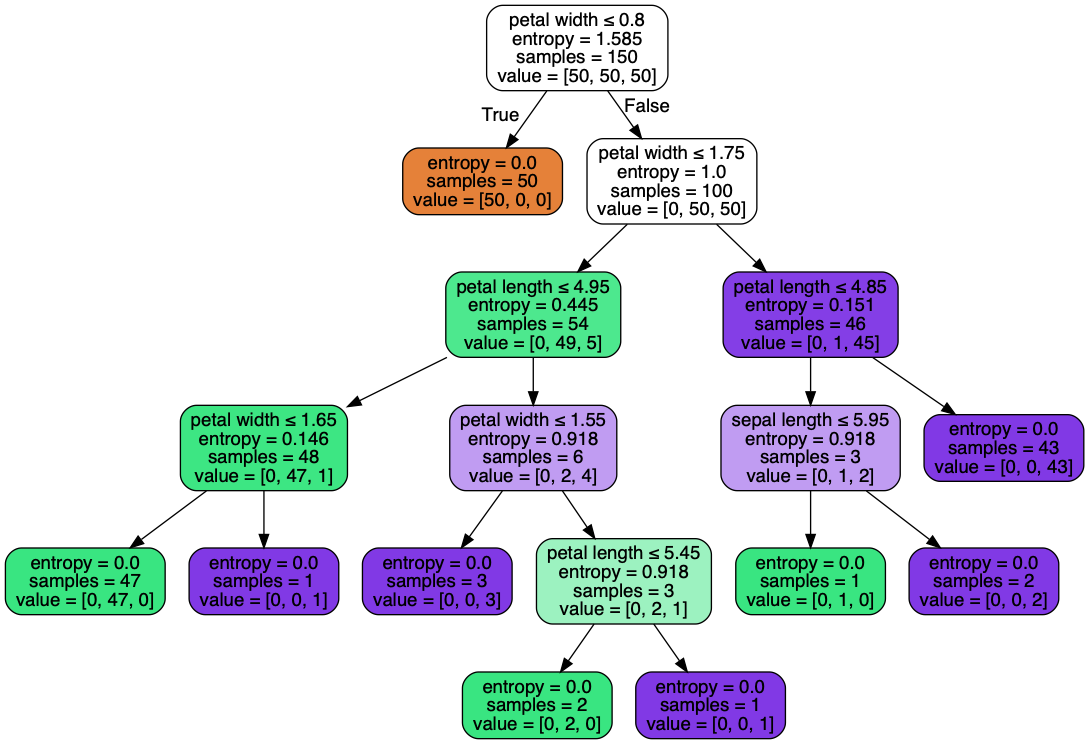

In [10]:
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

data = load_iris()
c45 = tree.DecisionTreeClassifier(criterion="entropy")
c45.fit(data.data, data.target)
y_pred = c45.predict(data.data)

dot_data = StringIO()
export_graphviz(c45, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=["sepal length","sepal width","petal length", "petal width"],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Notice that the first two splits come to us from pedal width - also deemed the most important feature.  This tells us that those features who split the tree first are likely the most important.  IE, the features as close to the root node as possible are the most important.

Unsurprisingly, petal length splits the tree next and it's also the second most important feature.  Then we see sepal length in the next split level.  But only a little.  It turns out petal width is so important, it splits the tree again.  As we can see from the tree, sepal width isn't even used to split the tree, so we can likely remove it from our model without lossing any accuracy.

While the above picture is clearly better, because it shows you in detail the importance of different features, unfortunately most tree based models are far more complex than this, pictorially.  This is because of the size of most datasets you'll encounter in the real world and because of the number of features you'll likely use.  This makes the tree _extremely_ hard to interpret visually using pictures like the above.  That's where feature importances and other ranking algorithms can really shine.

Let's look at an example for regression next:

('no_previous', 0.8614224137569221)
('not_distracted', 0.1219289843879403)
('ins_premium', 0.012471268195600476)
('speeding', 0.002230213170599606)
('alcohol', 0.0011545394536423656)
('ins_losses', 0.0007925810352951717)


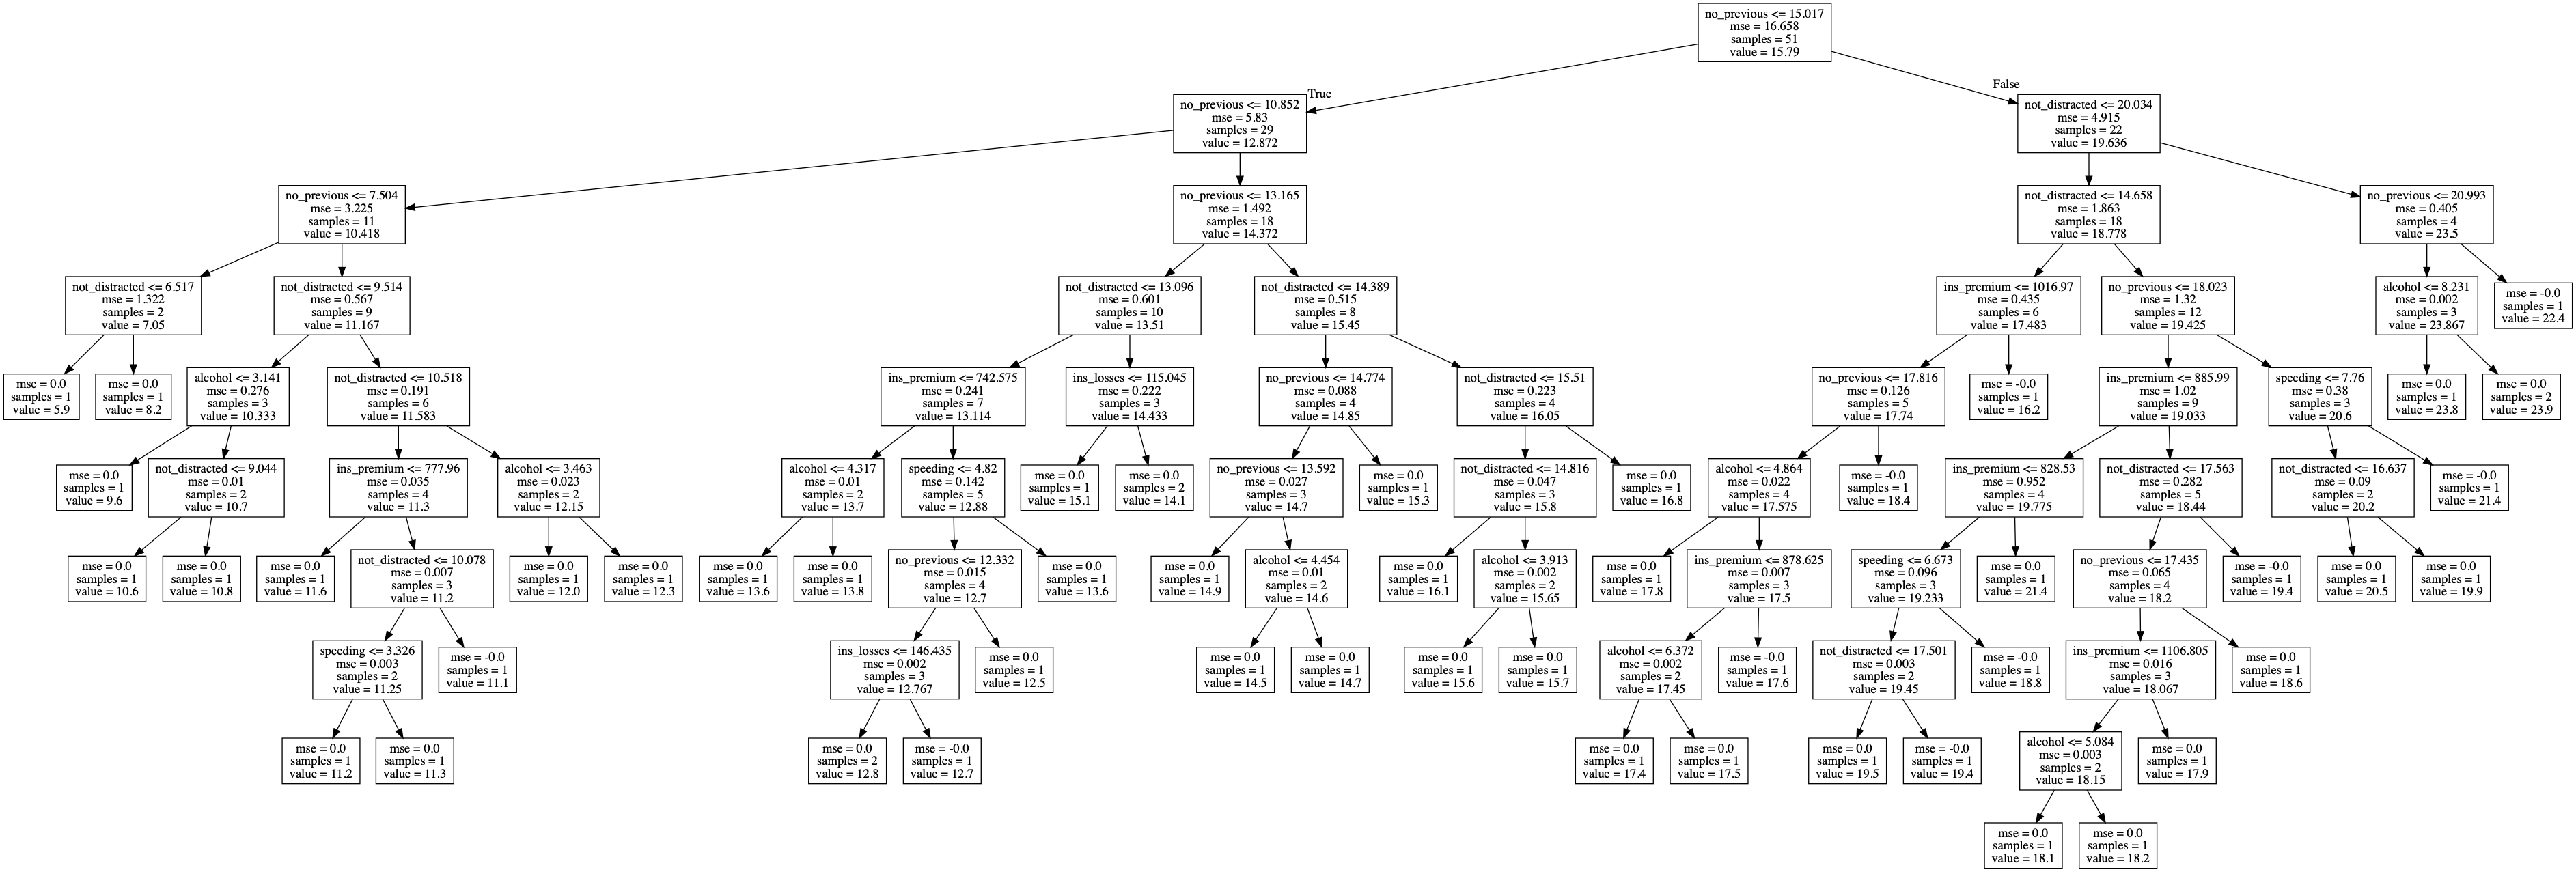

In [132]:
from sklearn import tree
from sklearn import metrics
from scipy import stats
import seaborn as sns

crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
features = ["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium", "ins_losses"]
X = crashes[features]
y = crashes["total"]
c45 = tree.DecisionTreeRegressor()
c45.fit(X, y)
y_pred = c45.predict(X)

feature_importances = []
for index, feature_name in enumerate(features):
    feature_importances.append((feature_name, c45.feature_importances_[index]))
for elem in sorted(feature_importances, key=lambda t:t[1], reverse=True):
    print(elem)

reg_dot_data = export_graphviz(c45,
                               out_file=None,
                               feature_names=features
                              )
reg_graph = pydotplus.graph_from_dot_data(reg_dot_data)
Image(reg_graph.create_png())

## Local Interpretation - Tree Interpreter

As you can see, we can rank the features and it appears that `no_previous` is the most important feature.  Notice that the tree visualization is much less useful here, this is because there aren't discrete buckets for a regression problem, so there is a much greater complexity to visualizing the tree.  That said, there is a way to get a sense of the structure of a decision tree used for regression - tree interpreter.

The tree interpreter package is part of a set of tools to do local interpretation within a complex model.  What does local interpretation mean?

It means, instead of looking at all of the example predictions that build towards a model, look instead at specific examples of the model.  This allows us to construct a sort of linear analysis of representative examples from our model.

Let's see an example:

In [36]:
from treeinterpreter import treeinterpreter as ti
import numpy as np
from sklearn import tree
from sklearn import metrics
from scipy import stats
import seaborn as sns

crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
features = ["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium", "ins_losses"]
X = crashes[features]
y = crashes["total"]
c45 = tree.DecisionTreeRegressor()
c45.fit(X, y)

instances = X.values[[0, 10]]
print("Instance 0 prediction:", c45.predict(instances[0].reshape(-1, 1).T))
print("Instance 1 prediction:", c45.predict(instances[1].reshape(-1, 1).T))

Instance 0 prediction: [23.9]
Instance 1 prediction: [19.4]


With local interpretation, we can now ask - why did the model predict 23.9 total crashes per 50,000 miles for the first instance from the dataset and 19.4 total crashes per 50,000 miles for the second instance from the dataset?

First we need to feed the model and the instances of interest into tree interpreter:

In [37]:
prediction, bias, contributions = ti.predict(c45, instances)

The above will give us back a "linear" model for each instance of the form:

$$ prediction = bias + feature_{1}contribution + feature_{2}contribution + ... + feature_{n}contribution $$

In [43]:
for i in range(len(instances)):
    print("Instance", i)
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 features), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)

Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 4.21
not_distracted 3.86
alcohol 0.03
speeding 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Instance 1
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 3.45
not_distracted -0.21
ins_premium 0.2
alcohol 0.17
speeding 0.0
ins_losses 0.0
--------------------


As you can see, for each of the instances, we can look at the contribution for each prediction.  For the first instance, the predicted score is higher than the second instance - 23.9 and 19.4 respectively.

My guess is since no_previous has a high contribution and alcohol is very low, it's likely instance 1 is a reckless driver, so even though they aren't distracted, their recklessness leads to a higher chance of getting in a crash for every 50,000 miles.  It's possible this is because this driver is inexperienced and that's why they are so reckless.  Whereas in the second case, we have a lower contribution of no_previous meaning the driver may be more cautiou because they've been in more accidents than the other driver.  Additionally, here not_distracted has a negative impact, meaning it drives down the number of crashes per 50,000 miles.  That means this driver is likely more experienced because when they are paying attention it is less likely they will get into a crash.  Interestingly alcohol is a bigger contributor, probably because a larger precentage of this type of driver can drink, reinforcing the notion that the first driver is a novice while the second instance is more experienced.

Basically, what the above analysis shows us is, we can build a narative around the contributions tree interepreter shows us.  But show we trust these naratives?  Can we single out individual examples and try to understand how the model is working overall?

To some degree these are open questions, but it is possible to pick so called "representative" examples from your dataset, to ensure that the examples chosen do generalize.  

One of the first things we can do is see the set of predicted values and the proportion of the dataset that gets each prediction:

In [46]:
y_pred = c45.predict(X)
print(len(set(y_pred))/len(y_pred))

0.8823529411764706


As we can see from the above most of the predictions are different, which means we might get some value from looking at the cases where they are the same and seeing if the contributions are consistent for those cases:

In [49]:
def value_counts(listing):
    value_count = {}.fromkeys(listing, 0)
    for elem in listing:
        value_count[elem] += 1
    return value_count

value_count = value_counts(y_pred)
repeat_values = []
for value in value_count:
    if value_count[value] > 1:
        print(value)
        repeat_values.append(value)

23.9
21.4
19.4
14.1
13.6
12.8


Let's see if the repeated values have the same contributions per feature:

In [68]:
from collections import defaultdict
def compare_instances(model, instances):
    prediction, bias, contributions = ti.predict(model, instances)
    for i in range(len(instances)):
        print("Instance", i)
        print("Bias (trainset mean)", bias[i])
        print("Feature contributions:")
        for c, feature in sorted(zip(contributions[i], 
                                     features), 
                                 key=lambda x: -abs(x[0])):
            print(feature, round(c, 2))
        print("-"*20)

def get_index_repeat(y, X, repeated_values):
    dicter = defaultdict(list)
    for index, elem in enumerate(y):
        if elem in repeated_values:
            dicter[elem].append(index)
    dicter = dict(dicter)
    instances = {}
    for value in dicter:
        instances[value] = X.values[dicter[value]]
    return instances

print(repeat_values)
instances = get_index_repeat(y, X, repeat_values)
for instance in instances:
    print("Predicted Value", instance)
    compare_instances(c45, instances[instance])

[23.9, 21.4, 19.4, 14.1, 13.6, 12.8]
Predicted Value 23.9
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 4.21
not_distracted 3.86
alcohol 0.03
speeding 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Instance 1
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 4.21
not_distracted 3.86
alcohol 0.03
speeding 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Predicted Value 21.4
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 3.45
ins_premium 2.37
not_distracted -0.21
speeding 0.0
alcohol 0.0
ins_losses 0.0
--------------------
Instance 1
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 5.02
speeding 0.8
not_distracted -0.21
alcohol 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Predicted Value 19.4
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 3.45
alcohol 0.96
ins_premium -0.59
not_distracted -0.21


Unsurprisingly, the contribution of features for:
* 12.8 crashes per 50,000 miles
* 14.1 crashes per 50,000 miles
* 23.9 crashes per 50,000 miles

have the same feature contributions per variable.  

However, suprisingly for:
* 21.4 crashes per 50,000 miles
* 19.4 crashes per 50,000 miles
* 13.6 crashes per 50,000 miles
* 12.8 crashes per 50,000 miles

The feature contributions were all different!!!  So we probably shouldn't use the same value for the output as a good indicator of representativeness for that class with respect to this model and data.  But more than that, it also tells us there is likely some overfitting!!!  We've got our first piece of valuable information from the dataset.  Let's see what else we can recover!

This time, we'll do dimensionality reduction and then clustering to figure out the right set of representative examples.

In order to do the dimensionality reduction, we'll try a few strategies.  First we'll make use of T-distributed Stochastic Neighborhood Embedding (aka T-SNE).  T-SNE makes use of KL-Divergence to try to minimize the difference between the low dimensional representation and the high dimensional representation.

In [93]:
from sklearn import manifold
from sklearn import decomposition 

embedding = manifold.TSNE(n_components=2, n_iter=2000).fit_transform(X)

In [94]:
from sklearn import neighbors
from sklearn import metrics
for k in range(2, 9):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn.fit(embedding, y)
    y_pred = knn.predict(embedding)
    print("K:", k)
    print("MSE:", metrics.mean_squared_error(y, y_pred))
    print("Median Absolute Error:", metrics.median_absolute_error(y, y_pred))

K: 2
MSE: 9.668725490196076
Median Absolute Error: 2.1499999999999986
K: 3
MSE: 14.130936819172112
Median Absolute Error: 3.133333333333333
K: 4
MSE: 15.025649509803921
Median Absolute Error: 2.9999999999999982
K: 5
MSE: 15.02838431372549
Median Absolute Error: 2.459999999999999
K: 6
MSE: 14.401111111111112
Median Absolute Error: 2.5500000000000007
K: 7
MSE: 14.507763105242097
Median Absolute Error: 2.2714285714285687
K: 8
MSE: 13.949944852941178
Median Absolute Error: 2.3750000000000018


What we can see here between the Mean Squared Error and the Median Absolute Error is our three choices are:
* 6 clusters
* 2 clusters
* 4 clusters

The two clusters minimizes mean squared error - so we'd be inclusive of the most outliers.  
The six clusters minimizes median absolutel error - so we'd be covering the most central data.
The four clusters is a middel ground between two and six - minimizing neither metric but meeting in the middle on both.

Given that no one metric should be followed religiously - we will go with four clusters.  

While I've used this technique _a lot_ in practice, I've had trouble finding it elsewhere except in a few papers, like [this one](https://arxiv.org/abs/1709.05262v2).  The older stapple for how to choose the right number of clusters is unsupervised metrics.  Let's see how if the two approaches agree:

In [95]:
from sklearn import metrics
from sklearn.cluster import KMeans
from time import time
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean')))

for k in range(2, 9):

    bench_k_means(KMeans(init='k-means++', n_clusters=k, n_init=10),
                  name="k-means++ {}".format(k), data=embedding, labels=y)

    bench_k_means(KMeans(init='random', n_clusters=k, n_init=10),
                  name="random {}".format(k), data=embedding, labels=y)



__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ 2	0.02s	40446	0.161	0.882	0.272	0.000	0.000	0.526
random 2 	0.01s	40446	0.161	0.882	0.272	0.000	0.000	0.526
k-means++ 3	0.02s	22017	0.262	0.901	0.406	0.000	0.001	0.455
random 3 	0.02s	22017	0.262	0.901	0.406	0.000	0.001	0.455
k-means++ 4	0.02s	16751	0.330	0.902	0.484	-0.003	-0.005	0.374
random 4 	0.01s	17000	0.330	0.902	0.484	-0.003	-0.005	0.365
k-means++ 5	0.02s	13787	0.392	0.931	0.552	0.007	0.010	0.326
random 5 	0.01s	13627	0.383	0.914	0.540	-0.001	-0.002	0.336
k-means++ 6	0.02s	11396	0.431	0.923	0.588	0.000	0.000	0.323
random 6 	0.01s	11740	0.430	0.923	0.586	0.000	0.000	0.307
k-means++ 7	0.03s	9960	0.471	0.929	0.625	0.002	0.003	0.320
random 7 	0.01s	10434	0.473	0.929	0.627	0.002	0.003	0.278
k-means++ 8	0.02s	8666	0.505	0.921	0.653	-0.009	-0.010	0.295
random 8 	0.01s	8370	0.504	0.921	0.652	-0.009	-0.010	0.308


For the above scores higher is better and lower is worse.  Each measures a different aspect of clustering:

* homogeneity: each cluster contains only members of a single class.
* completeness: all members of a given class are assigned to the same cluster.
* V-Measure: This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.  It is also the same as normalized mutual information score 'arithmetic' option for averaging (in sklearn).
* ARI: The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
* AMI: Adjusted mutual information.
* The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

Here we see that the best choice overall appears to be k-means++ with 6 clusters.  k-means++ with four clusters still does fine.  Interestingly, we can see that the silhouette score is the highest for k-means++ with two clusters, mimicing our analysis with KNNs -

So 6 clusters does the best in same ways, 2 clusters does the best in others and 4 clusters is somewhere in the middle again!  Given how poorly 4 clusters does in some areas, let's visualize 2, 4 and, 6 clusters for a final determination:

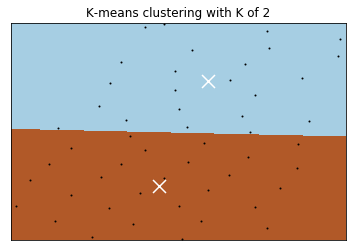

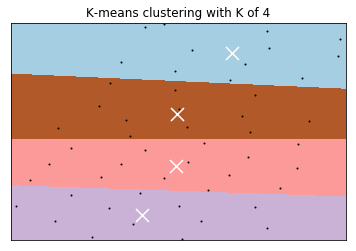

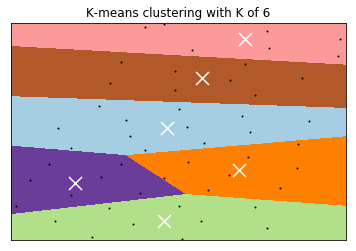

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_kmeans_clusters(embedding, k):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(embedding)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = embedding[:, 0].min() - 1, embedding[:, 0].max() + 1
    y_min, y_max = embedding[:, 1].min() - 1, embedding[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(embedding[:, 0], embedding[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering with K of {}'.format(k))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

plot_kmeans_clusters(embedding, 2)
plot_kmeans_clusters(embedding, 4)
plot_kmeans_clusters(embedding, 6)

As you can see TSNE does an okay job, let's see how PCA does:

In [98]:
from sklearn import neighbors
from sklearn import metrics

def find_k(embedding, y):
    for k in range(2, 9):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k)
        knn.fit(embedding, y)
        y_pred = knn.predict(embedding)
        print("K:", k)
        print("MSE:", metrics.mean_squared_error(y, y_pred))
        print("Median Absolute Error:", metrics.median_absolute_error(y, y_pred))
    
embedding = decomposition.PCA(n_components=2).fit_transform(X)
find_k(embedding, y)

K: 2
MSE: 7.223284313725489
Median Absolute Error: 2.1999999999999993
K: 3
MSE: 11.5720697167756
Median Absolute Error: 2.4333333333333336
K: 4
MSE: 13.99033088235294
Median Absolute Error: 2.8749999999999964
K: 5
MSE: 14.559466666666665
Median Absolute Error: 2.5999999999999996
K: 6
MSE: 15.520740740740736
Median Absolute Error: 2.6999999999999975
K: 7
MSE: 15.205242096838735
Median Absolute Error: 2.7714285714285722
K: 8
MSE: 14.811167279411762
Median Absolute Error: 2.8125


Overall the error is lower for PCA than TSNE.  Let's see if PCA leads to better unsupervised learning scores:

In [99]:
from sklearn import metrics
from sklearn.cluster import KMeans
from time import time
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean')))

for k in range(2, 9):

    bench_k_means(KMeans(init='k-means++', n_clusters=k, n_init=10),
                  name="k-means++ {}".format(k), data=embedding, labels=y)

    bench_k_means(KMeans(init='random', n_clusters=k, n_init=10),
                  name="random {}".format(k), data=embedding, labels=y)


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ 2	0.02s	419177	0.146	0.910	0.252	0.001	0.005	0.653
random 2 	0.01s	419177	0.146	0.910	0.252	0.001	0.005	0.653
k-means++ 3	0.01s	242032	0.244	0.871	0.381	-0.005	-0.011	0.498
random 3 	0.01s	243302	0.246	0.872	0.384	-0.005	-0.010	0.495
k-means++ 4	0.01s	123330	0.296	0.911	0.447	0.001	0.001	0.562
random 4 	0.02s	123885	0.305	0.914	0.457	0.001	0.002	0.540
k-means++ 5	0.02s	76357	0.374	0.912	0.531	-0.002	-0.003	0.546
random 5 	0.01s	76911	0.383	0.914	0.540	-0.001	-0.002	0.545
k-means++ 6	0.02s	45781	0.412	0.920	0.569	-0.001	-0.001	0.572
random 6 	0.01s	45781	0.412	0.920	0.569	-0.001	-0.001	0.572
k-means++ 7	0.02s	36737	0.455	0.927	0.610	0.001	0.001	0.545
random 7 	0.01s	36747	0.456	0.927	0.611	0.001	0.001	0.541
k-means++ 8	0.02s	31122	0.499	0.920	0.647	-0.009	-0.010	0.489
random 8 	0.01s	32261	0.484	0.918	0.634	-0.009	-0.011	0.518


As you can see, the unsupervised learning scores are better for PCA than TSNE as well.

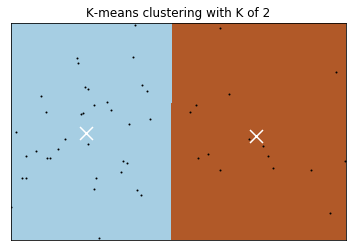

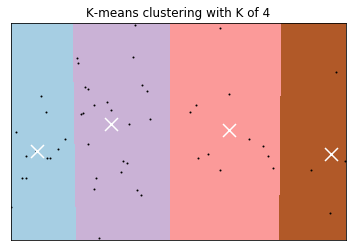

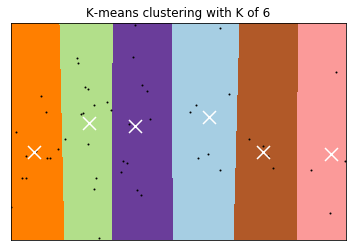

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_kmeans_clusters(embedding, k):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(embedding)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = embedding[:, 0].min() - 1, embedding[:, 0].max() + 1
    y_min, y_max = embedding[:, 1].min() - 1, embedding[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(embedding[:, 0], embedding[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering with K of {}'.format(k))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

plot_kmeans_clusters(embedding, 2)
plot_kmeans_clusters(embedding, 4)
plot_kmeans_clusters(embedding, 6)

It looks like PCA with 4 clusters is the best.  This gives us some initial confirms our supervised learning method works as well as the unsupervised metrics + visualization.  Let's work with the uncompressed data now and see if we can get metric scores close to the 4 clusters:

In [101]:
from sklearn import metrics
from sklearn.cluster import KMeans
from time import time
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean')))

for k in range(2, 9):

    bench_k_means(KMeans(init='k-means++', n_clusters=k, n_init=10),
                  name="k-means++ {}".format(k), data=X, labels=y)

    bench_k_means(KMeans(init='random', n_clusters=k, n_init=10),
                  name="random {}".format(k), data=X, labels=y)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++ 2	0.02s	421185	0.146	0.910	0.252	0.001	0.005	0.651
random 2 	0.01s	421185	0.146	0.910	0.252	0.001	0.005	0.651
k-means++ 3	0.02s	243933	0.244	0.871	0.381	-0.005	-0.011	0.495
random 3 	0.01s	245209	0.246	0.872	0.384	-0.005	-0.010	0.491
k-means++ 4	0.02s	125289	0.296	0.911	0.447	0.001	0.001	0.556
random 4 	0.02s	125863	0.305	0.914	0.457	0.001	0.002	0.534
k-means++ 5	0.02s	78274	0.374	0.912	0.531	-0.002	-0.003	0.537
random 5 	0.01s	78848	0.383	0.914	0.540	-0.001	-0.002	0.535
k-means++ 6	0.02s	47693	0.412	0.920	0.569	-0.001	-0.001	0.560
random 6 	0.01s	47693	0.412	0.920	0.569	-0.001	-0.001	0.560
k-means++ 7	0.03s	38630	0.456	0.927	0.611	0.001	0.001	0.527
random 7 	0.01s	38630	0.456	0.927	0.611	0.001	0.001	0.527
k-means++ 8	0.02s	32978	0.503	0.933	0.653	0.003	0.004	0.483
random 8 	0.01s	34150	0.484	0.918	0.634	-0.009	-0.011	0.502


It looks like the 4 cluster K-means stays pretty close to the 4 cluster PCA + K-means!!  So now we are ready to take our candidate examples which as as close to the k-means centriods as possible:

In [128]:
from sklearn.metrics import pairwise

def find_closest_points(k, X, y):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(X, y)
    closest_points = []
    indices = []
    for centroid in k_means.cluster_centers_:
        min_dist = 999999999
        min_index = 0
        for index, elem in enumerate(X.values):
            dist = sum(pairwise.euclidean_distances([elem], [centroid]))
            if dist < min_dist:
                min_dist = dist
                min_index = index
        indices.append(min_index)   
        closest_points.append(X.values[min_index])
    return closest_points, indices

closest_points, indices = find_closest_points(4, X, y)

In [129]:
for index, point in enumerate(closest_points):
    print("Predicted value:", indices[index])
    compare_instances(c45, np.array([point]))

Predicted value: 35
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous -1.56
not_distracted -0.4
ins_premium -0.23
speeding 0.0
alcohol 0.0
ins_losses 0.0
--------------------
Predicted value: 46
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous -5.27
not_distracted 0.28
speeding 0.0
alcohol 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Predicted value: 1
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous 4.21
not_distracted 3.86
alcohol 0.03
speeding 0.0
ins_premium 0.0
ins_losses 0.0
--------------------
Predicted value: 50
Instance 0
Bias (trainset mean) 15.790196078431373
Feature contributions:
no_previous -5.37
not_distracted -3.37
ins_losses -1.15
speeding 0.0
alcohol 0.0
ins_premium 0.0
--------------------


We can now see pretty clearly from all our hard work:

* no_previous is the largest contributing factor in every case - therefore we can say nothing beats experience
* It looks like the high predicted cases had previous accidents because the contribution is negative
* not_distracted is the second most important thing - this explains all those campaigns about texting while driving.  Clearly it very strong effects things.
* has much less to do with it, but in 2 of the 4 cases, if a driver was distracted, they were more likely to get into a crash
* Not being distracted clearly has a lot more to do with not getting into a crash - the case with only 1 predicted crash, the driver was cautious (not distracted) and had no previous crashes on their record.

So I think we can safely trust our model at least to some degree.  It certainly feels semantically consistent with what one would expect.  

## Local Interpretable Model-agnostic Explainations

With tree interpreter we have a reasonably good way of interpreting models for regression, you can use tree interpreter for classification analysis as well, but it doesn't do as good a job, in my opinion.

Now let's look at one that's great for classification called Local Interpretable Model agnostic Explainations aka LIME.

Since we already understand the the power of interpretting individual examples, let's just take a quick tour of the API.  To do this we'll return to our iris dataset:

In [6]:
from sklearn import tree
from sklearn.datasets import load_iris
from lime import lime_tabular
import numpy as np

data = load_iris()
c45 = tree.DecisionTreeClassifier(criterion="entropy")
c45.fit(data.data, data.target)
y_pred = c45.predict(data.data)

explainer = lime_tabular.LimeTabularExplainer(data.data, 
                                              feature_names=data.feature_names, 
                                              class_names=data.target_names, 
                                              discretize_continuous=True)
i = np.random.randint(0, data.data.shape[0])
exp = explainer.explain_instance(data.data[i], c45.predict_proba, num_features=2, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

The way LIME works is it builds local linear models to interpret the individual examples of the broader model.  As you can see we can visualize how our model behaved for this class.  As you can see, like before petal width and sepal width both had the largest contributing factors!  So our explainer does a good job for this case!

## SHAP Scores

Now that we've looked at how to analyze local models, let's turn our attention to SHAP.  SHAP is a fast version of something called the Shapley value.  We can think of a Shapley value as a game theoretic notion of analyzing how a model's features contribute to it's predictions.  We can think of a shapley value is sort of like the local explainations in that you look at the contributions of each feature to the overall model output, except you don't look at individual examples - you look at the _overall_ contribution.  Basically, SHAP values show us both the forest and the trees.  Each data point, represents an individual explaination and the combination of all data points shows us those explainations in context of all other local explainations.  Therefore, we don't need to go through the work of discovering representative explainations and understanding each of those individually, like we did prior with tree interpreter.  More formally, Shapley values look at the feature importance per feature to the model prediction and consider the model prediction with and without the feature.

The general interpretation for shap values: 

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

Let's look at an example:

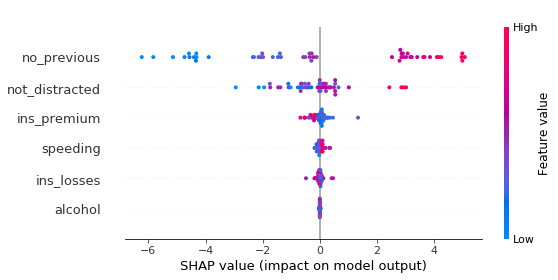

In [3]:
import shap
import numpy as np
from sklearn import tree
from sklearn import metrics
from scipy import stats
import seaborn as sns

crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
features = ["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium", "ins_losses"]
X = crashes[features]
y = crashes["total"]
c45 = tree.DecisionTreeRegressor()
c45.fit(X, y)

shap_values = shap.TreeExplainer(c45).shap_values(X)
shap.summary_plot(shap_values, X)

As you can see no_previous has the largest impact on the model output - this is because the values are the most spread out.  We can see this as the marginal effect taken over the average effect.  We can see when the feature value for no_previous is low the SHAP value is low, meaning as you increase no_previous the model prediction increases.  We can think of this as a "positive" relationship.

Juxtapose that with ins_premium, as ins_premium feature value increases the SHAP value decreases, meaning we can think ofthis as a "negative" relationship.  

We also see that alcohol tends to have no effect on changing the average prediction and ins_losses seems to also have a very small effect.

Now that we know overall how the individual predictions together effect the average prediction, let's look at some individual relationships in detail.  In order to do this we'll look at the dependency plot:

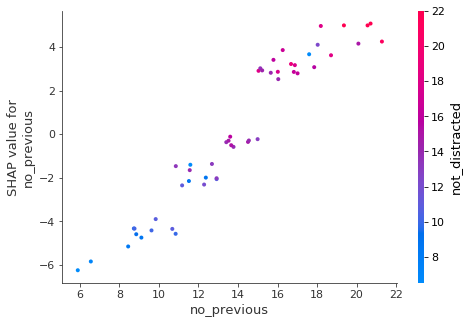

In [4]:
shap.dependence_plot("no_previous", shap_values, X)

By drilling down into the individual plot we see the clear positive relationship between the feature values of no_previous and SHAP values for no_previous, but we also see the relationship between no_previous and not_distracted.  Interestingly, it looks like when no_previous is low, so is not_distracted, however there are a few low values for not distracted when no_previous is higher.  These cases are likely the unexperienced drivers we saw previously!  

That's the power of SHAP - look at how little work we need to do to recover the same analysis as before!  We can go even further:

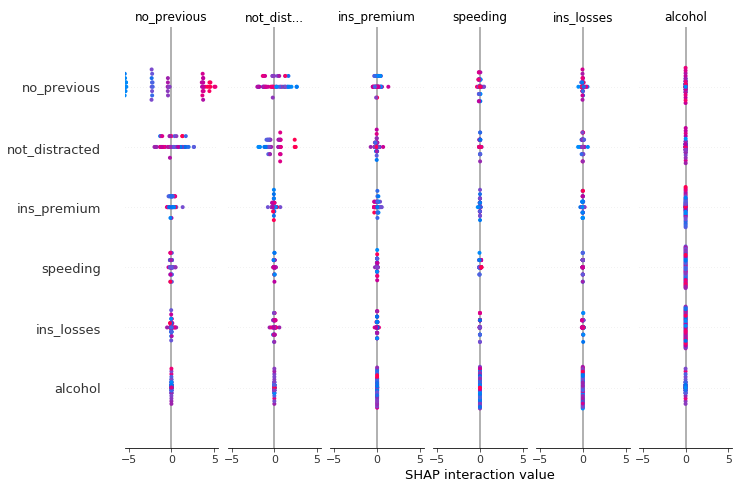

In [6]:
shap_interaction_values = shap.TreeExplainer(c45).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

Now we can see all the marginal effects together in one plot!  For instance, although alcohol by itself does not seem to vary much, it varies at somewhat with respect to each of the other variables.

Overall, this gives us a powerful low dimensional representation of many high dimensional interactions.  It allows us to deconstruct these complex interactions into component pieces, all while in the context of the larger context of model prediction.

We can also of course interrogate individual features within this context as well.  Let's start by comparing a feature to its SHAP values:

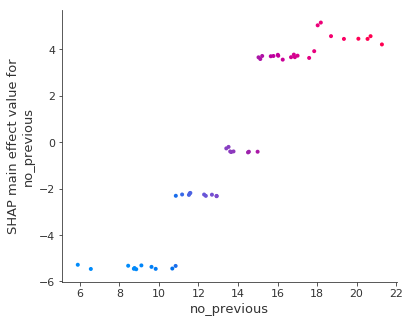

In [7]:
shap.dependence_plot(
    ("no_previous", "no_previous"),
    shap_interaction_values,
    X)

Interestingly it looks like the SHAP value segments no_previous quite well!  The lower values stay around -5.5 while the higher values are all clustered around 4!

Now let's look at an interaction between no_previous and not_distracted:

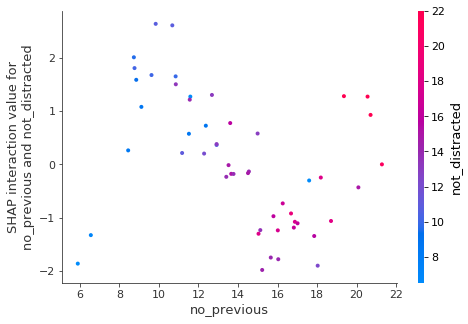

In [8]:
shap.dependence_plot(
    ("no_previous", "not_distracted"),
    shap_interaction_values,
    X)

As you can see the lower values distribute across the SHAP values, but the higher values tend to cluster around a negative SHAP score!  This gives a very clear sense of the combined marginal contribution of these two variables!

It appears as though these are the cases where a car crash was less likely to occur.

We can also look at the marginal interactions in a heatmap (what data science talk would be complete without one?!):

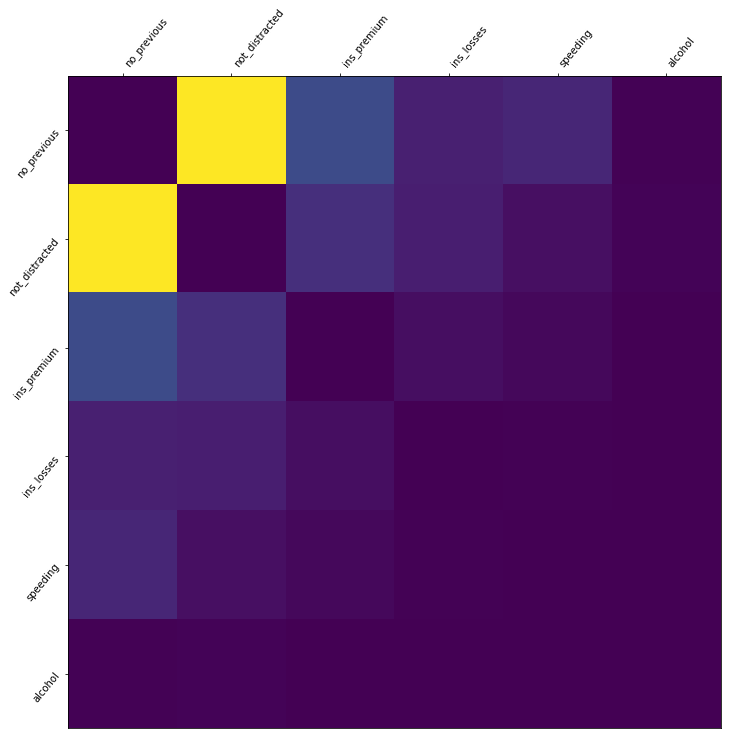

In [11]:
import matplotlib.pylab as pl
import numpy as np

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

Here a lighter colors mean higher summed scores and darker colors mean lower summed scores. 

General References:
   * [understanding tree interpreter](http://engineering.pivotal.io/post/interpreting-decision-trees-and-random-forests/)
   * [code for understanding tree interpreter](https://github.com/gregtam/interpreting-decision-trees-and-random-forests)
   * [blog post introducing SHAP](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83)
   * [interpretability book](https://christophm.github.io/interpretable-ml-book/shapley.html#disadvantages-12)